# 금기어종 
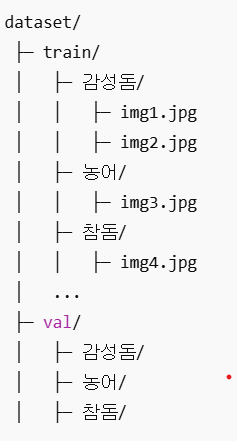

In [1]:
# 기본 학습 코드
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =========================
# 1) 하이퍼파라미터 설정
# =========================
img_height, img_width = 224, 224   # 입력 이미지 크기
batch_size = 32
epochs = 30

train_dir = "dataset/train"
val_dir   = "dataset/val"

# =========================
# 2) 데이터 불러오기 + 증강
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

num_classes = len(train_generator.class_indices)
print("클래스 라벨:", train_generator.class_indices)

# =========================
# 3) 모델 정의 (CNN)
# =========================
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# =========================
# 4) 학습
# =========================
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# =========================
# 5) 저장
# =========================
model.save("fish_species_model.h5")


IndentationError: unexpected indent (2651349641.py, line 56)

In [ ]:
# 예측하기

import numpy as np
from tensorflow.keras.preprocessing import image

# 이미지 불러오기
img_path = "test.jpg"   # 테스트할 어종 이미지
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

# 예측
pred = model.predict(x)
class_names = list(train_generator.class_indices.keys())
print("예측 결과:", class_names[np.argmax(pred)], " (확률:", np.max(pred), ")")


In [ ]:
예측 결과: 감성돔 (확률: 0.98)

In [ ]:
# 전이 학습시키기

In [ ]:
# 기본 학습 코드
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 전이 학습을 위한 라이브러리 추가
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

# =========================
# 1) 하이퍼파라미터 설정
# =========================
img_height, img_width = 224, 224 
batch_size = 32
epochs = 30

train_dir = "dataset/train"
val_dir   = "dataset/val"

# =========================
# 2) 데이터 불러오기 + 증강
# =========================
train_datagen = ImageDataGenerator(
    # EfficientNet은 입력 데이터를 [0, 1] 범위로 정규화하는 것을 선호합니다.
    rescale=1./255, 
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

num_classes = len(train_generator.class_indices)
print("클래스 라벨:", train_generator.class_indices)

# =========================
# 3) 모델 정의 (EfficientNetB0 전이 학습)
# =========================
# EfficientNetB0 모델을 불러오고, 마지막 fully connected 층은 제외합니다.
base_model = EfficientNetB0(
    weights='imagenet', # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    include_top=False,  # 최상위 분류 층 제외
    input_shape=(img_height, img_width, 3)
)

# 사전 학습된 가중치는 동결(freeze)하여 학습되지 않게 합니다.
base_model.trainable = False 

# 새로운 분류 층을 추가합니다.
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) # 특징 맵을 1차원 벡터로 변환
model.add(Dropout(0.2)) # 과적합 방지를 위한 Dropout 층
model.add(Dense(num_classes, activation="softmax")) # 최종 분류를 위한 출력 층


model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# =========================
# 4) 학습
# =========================
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# =========================
# 5) 저장
# =========================
model.save("fish_species_efficientnet_model.h5")